# Machine Learning
# RNN

In [ ]:
!pip install keras

In [ ]:
!pip install tensorflow

# With longer sequence length, different model architecture, dropout for regularization, and early stopping

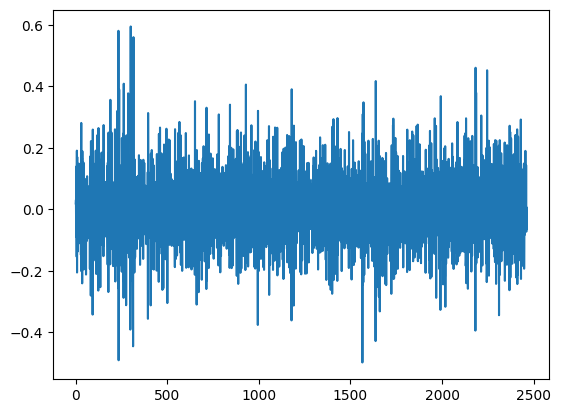

In [ ]:
# Import Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Load data (csv)
path = 'btc_nov20.csv'
df = pd.read_csv(path)

# Plot data
plt.plot(df['hashrate'])
plt.show()

# Features and target variable
features = ['volume',
            'spx', 'nasdaq', 'vix',
            'epu', 'gepu',
            'nft', 'cbdc_u', 'cbdc_a',
            'gt_web', 'gt_news',
            'SER', 'active add', 'over10k', 'over100k', 'over1m', 'over1k', 'mean trans fee',
            'total fee', 'miner rev', 'rev per hash', 'hashrate',
            'mean hashrate', 'blox', 'diffic', 'mean diffic', 'inflows', 'outflows',
            'transx', 'transf usd', 'transf']

target = 'ret'

In [ ]:
df.dtypes

Date               object
ret               float64
drxon               int64
log_vol           float64
volume            float64
spx               float64
nasdaq            float64
vix               float64
epu               float64
gepu              float64
nft               float64
cbdc_u            float64
cbdc_a            float64
gt_web            float64
gt_news           float64
SER               float64
active add        float64
over10k           float64
over100k          float64
over1m            float64
over1k            float64
mean trans fee    float64
total fee         float64
miner rev         float64
rev per hash      float64
hashrate          float64
mean hashrate     float64
blox              float64
diffic            float64
mean diffic       float64
inflows           float64
outflows          float64
transx            float64
transf usd        float64
transf            float64
dtype: object

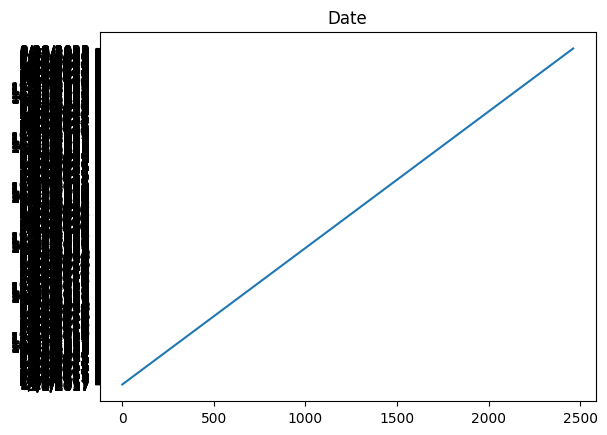

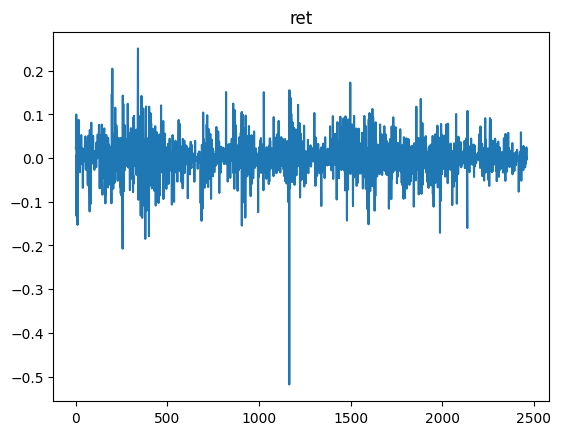

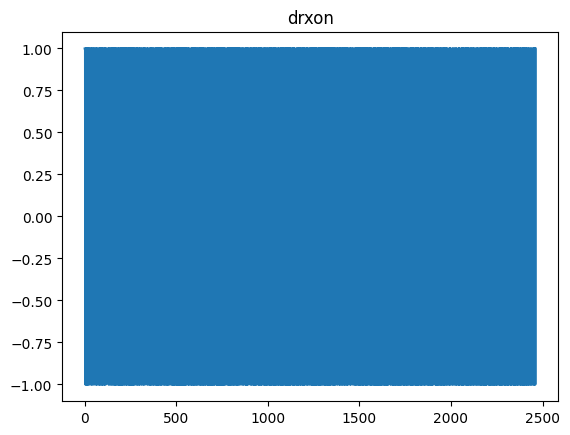

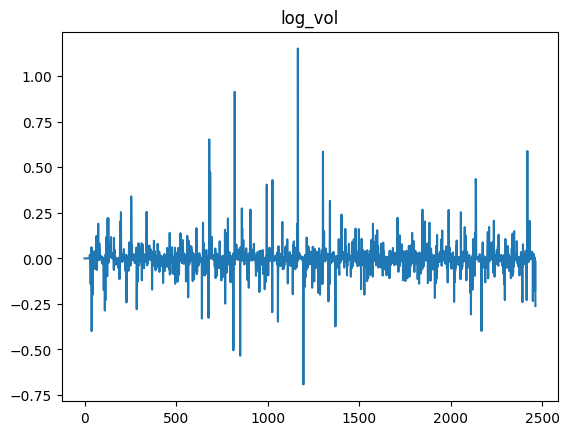

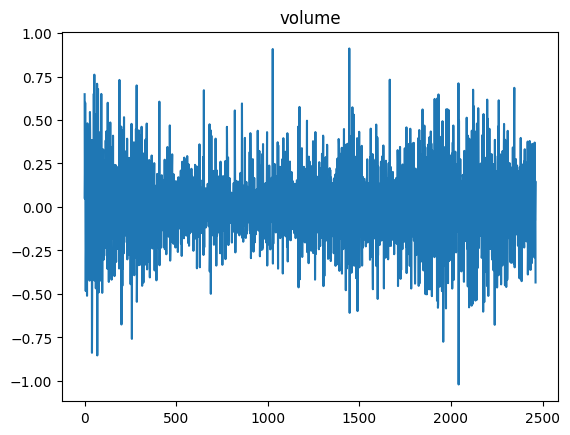

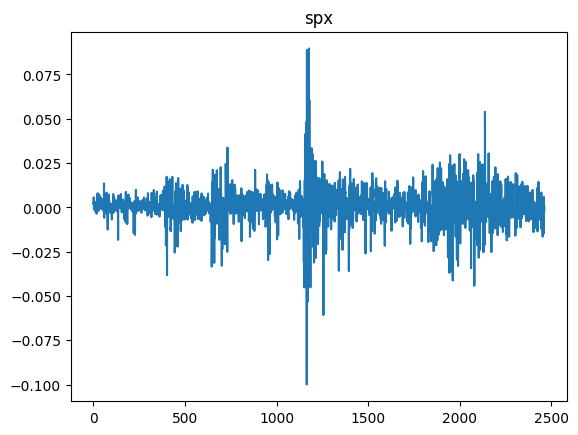

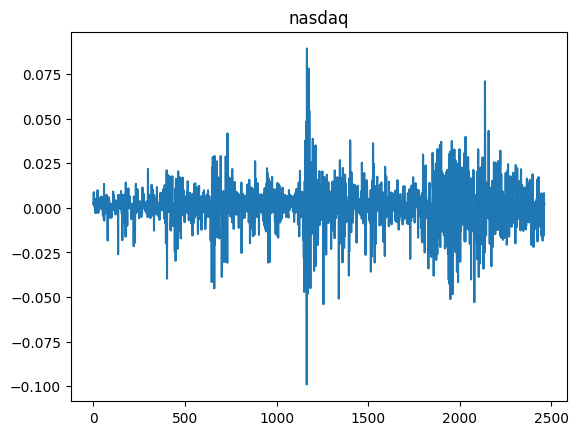

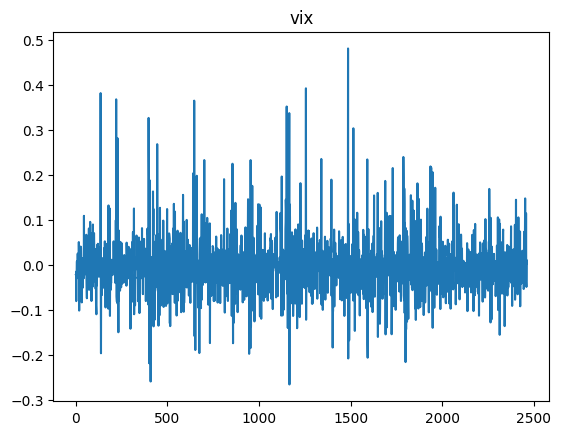

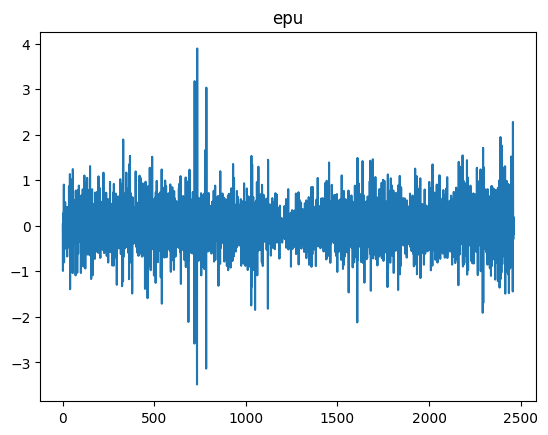

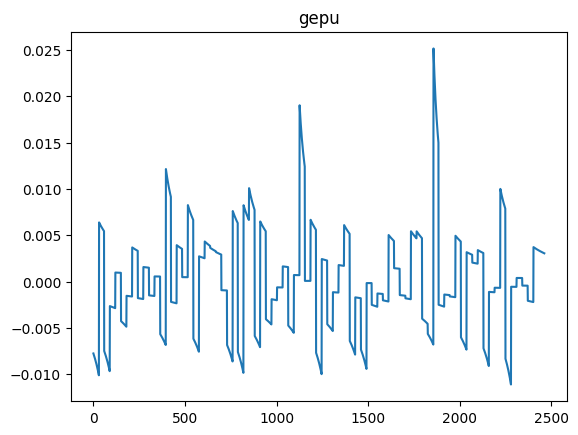

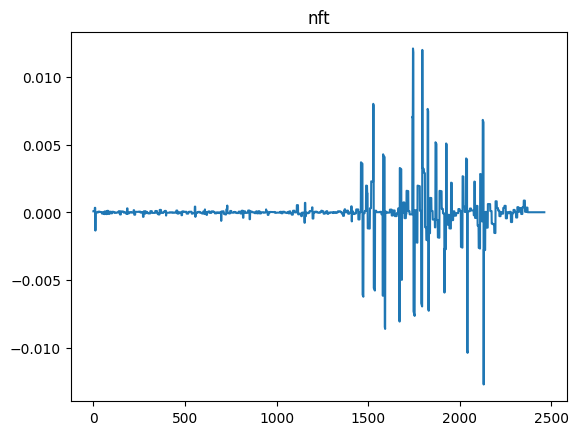

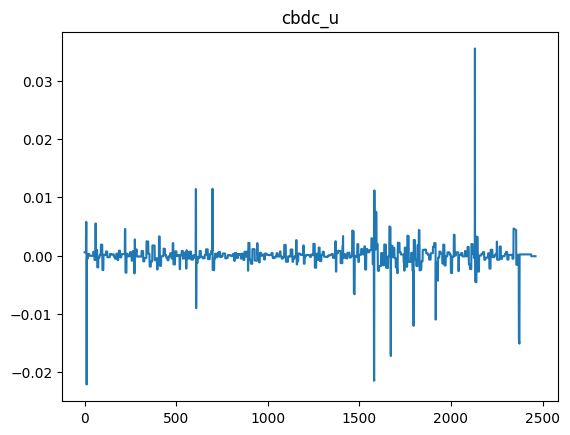

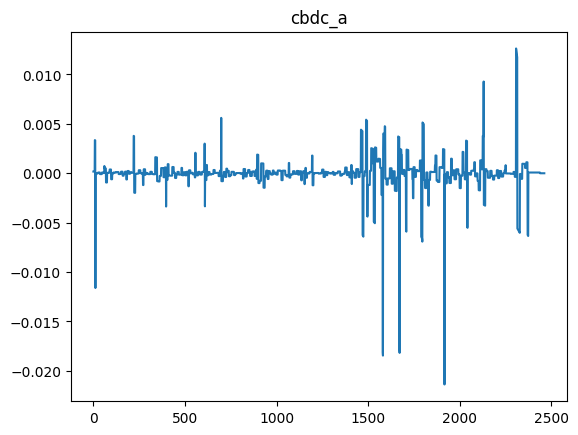

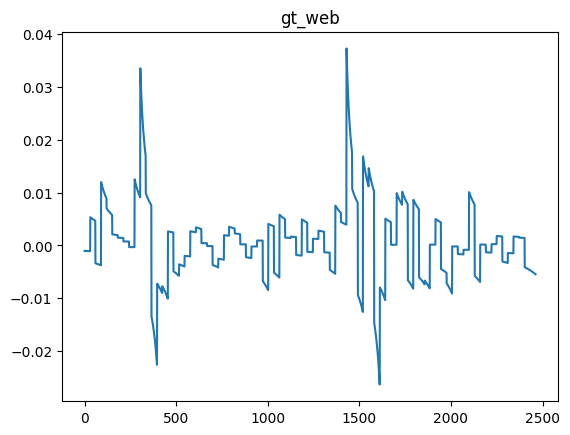

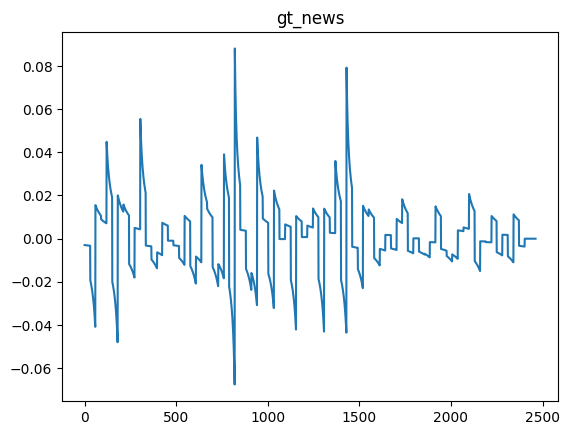

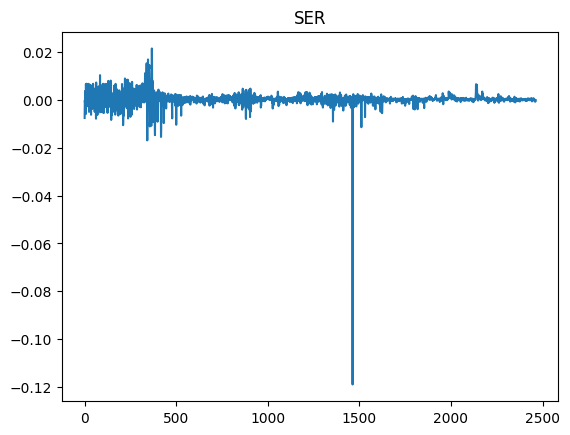

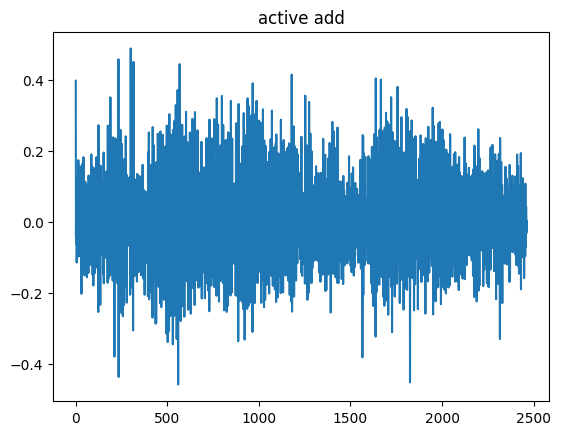

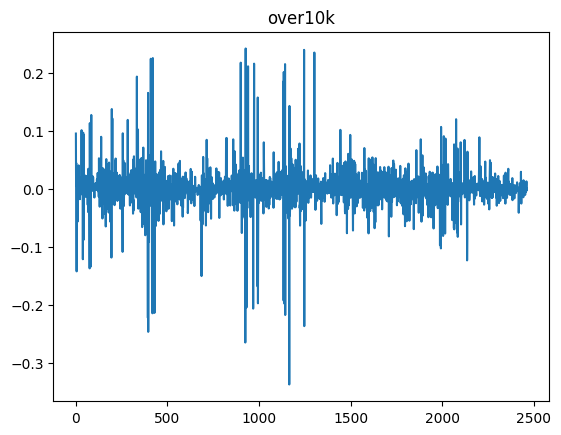

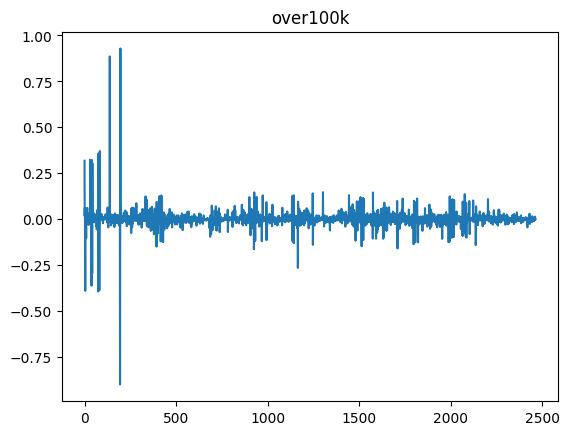

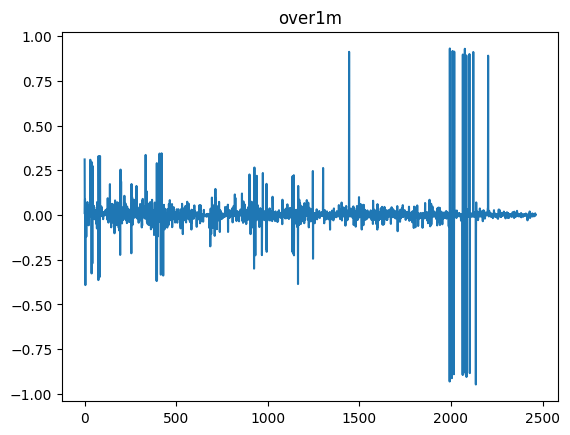

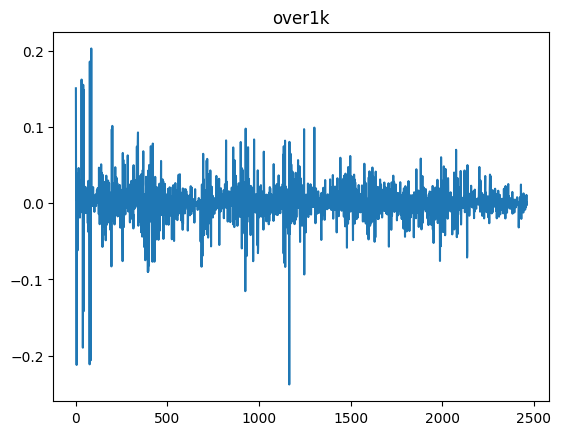

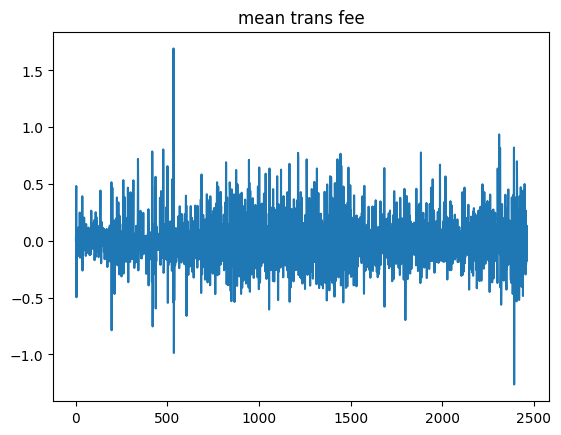

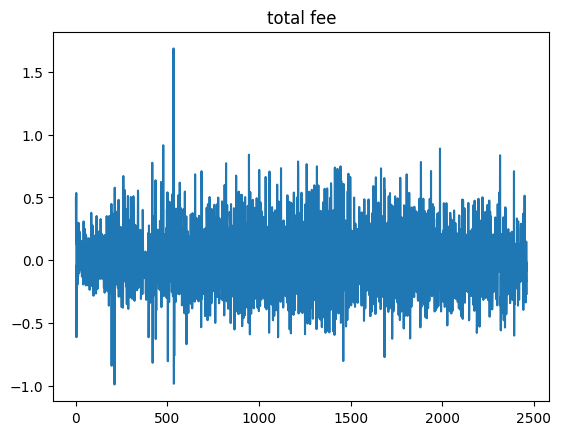

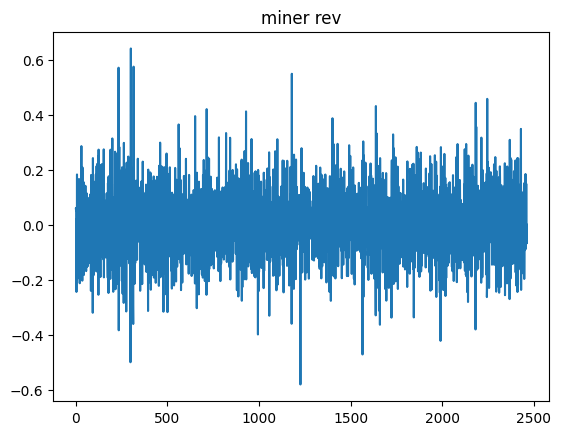

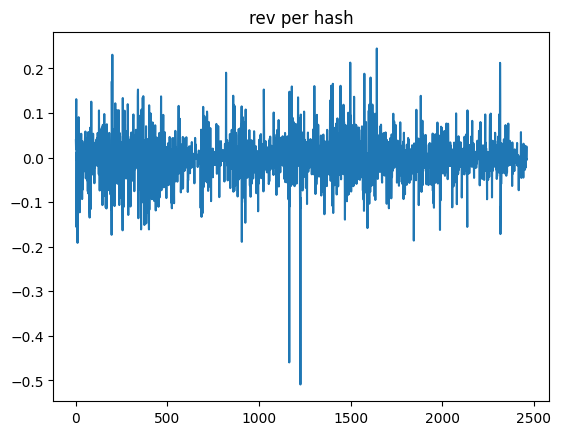

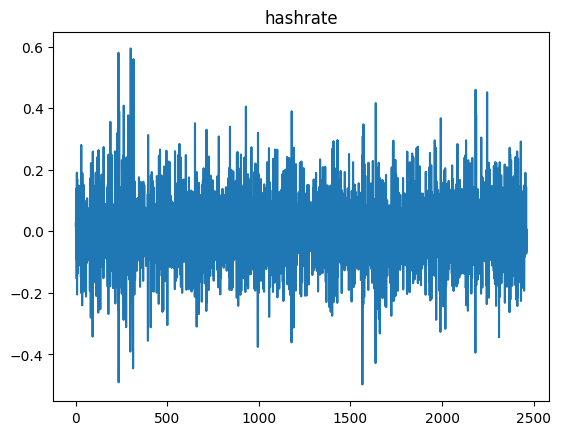

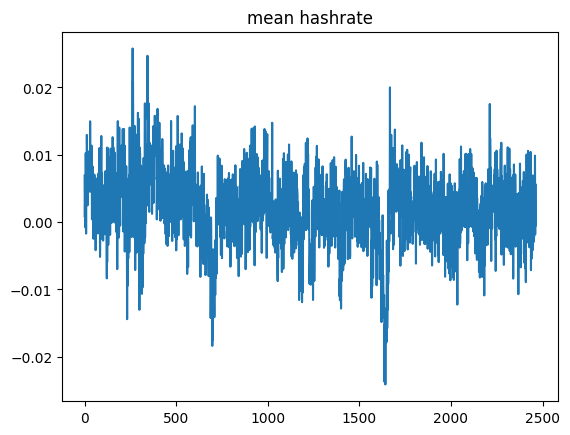

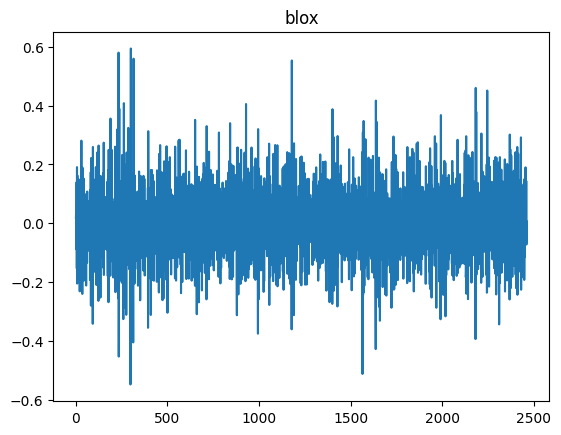

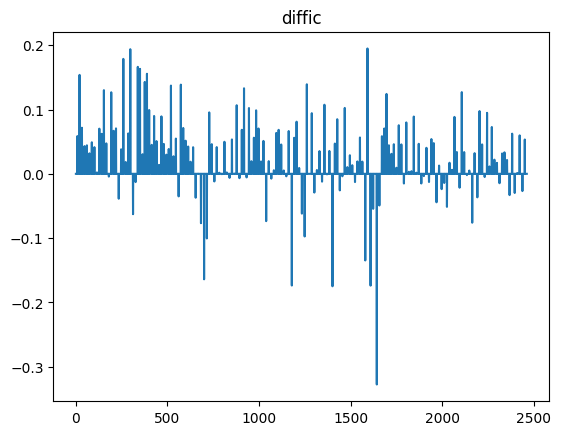

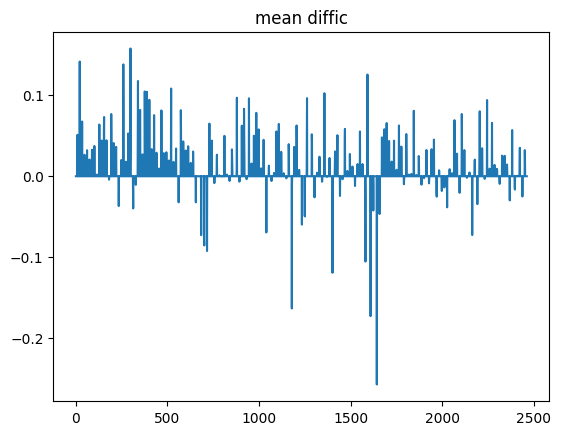

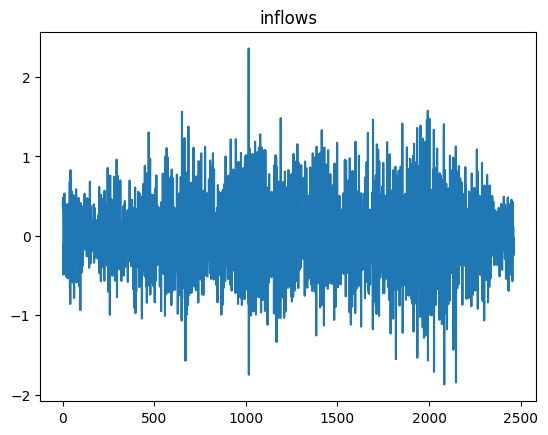

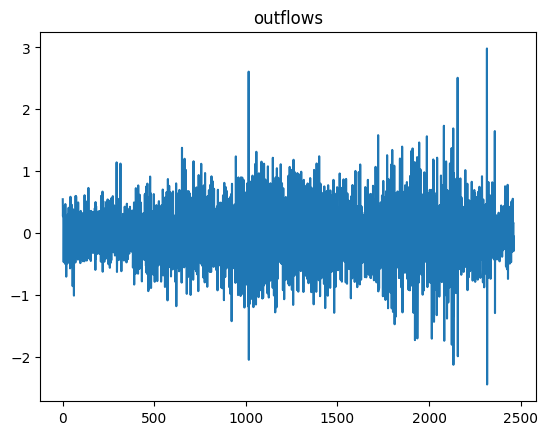

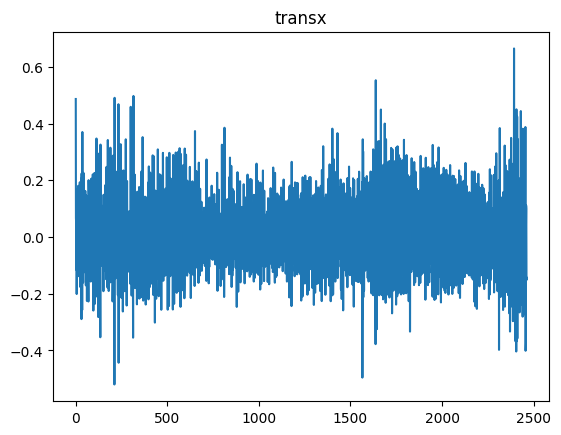

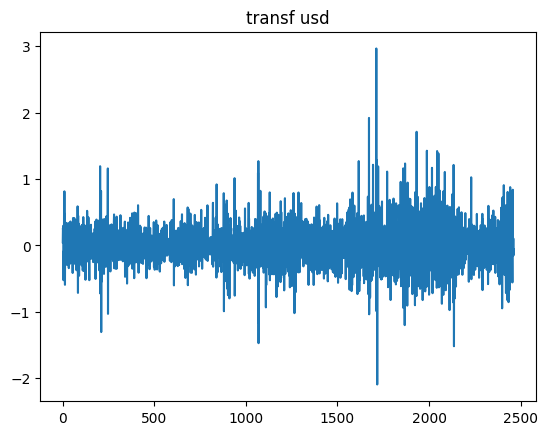

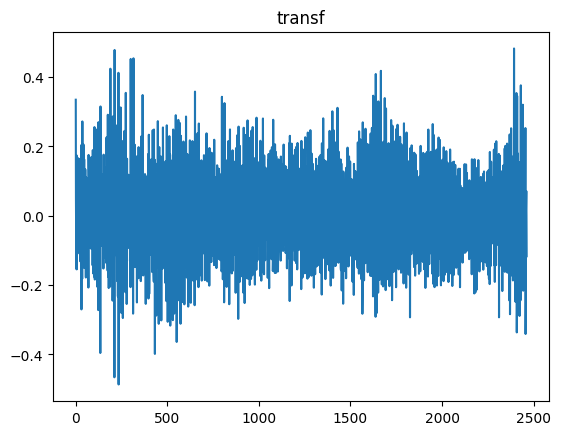

In [ ]:
for i in df.columns:
  plt.plot(df[i])
  plt.title(i)
  plt.show()

In [ ]:
df.Date

0        1/2/2017
1        1/3/2017
2        1/4/2017
3        1/5/2017
4        1/6/2017
          ...    
2458    9/26/2023
2459    9/27/2023
2460    9/28/2023
2461    9/29/2023
2462    9/30/2023
Name: Date, Length: 2463, dtype: object

## Experiment 1 - Split the training and testing across years
This pipeline is useful to find the baseline scores of our model. We first split
the data into training, testing, and validation. Then apply 5 different models to test performance.
Once we evaluate these models, we then find the important features.

               Model  Test MSE  Test MAE   Test R2
0  Linear Regression  0.000143  0.006139  0.723506
1   Ridge Regression  0.000141  0.006022  0.727272
2   Lasso Regression  0.000518  0.015212 -0.000500
3      Decision Tree  0.000052  0.004667  0.900570
4      Random Forest  0.000010  0.002003  0.981002


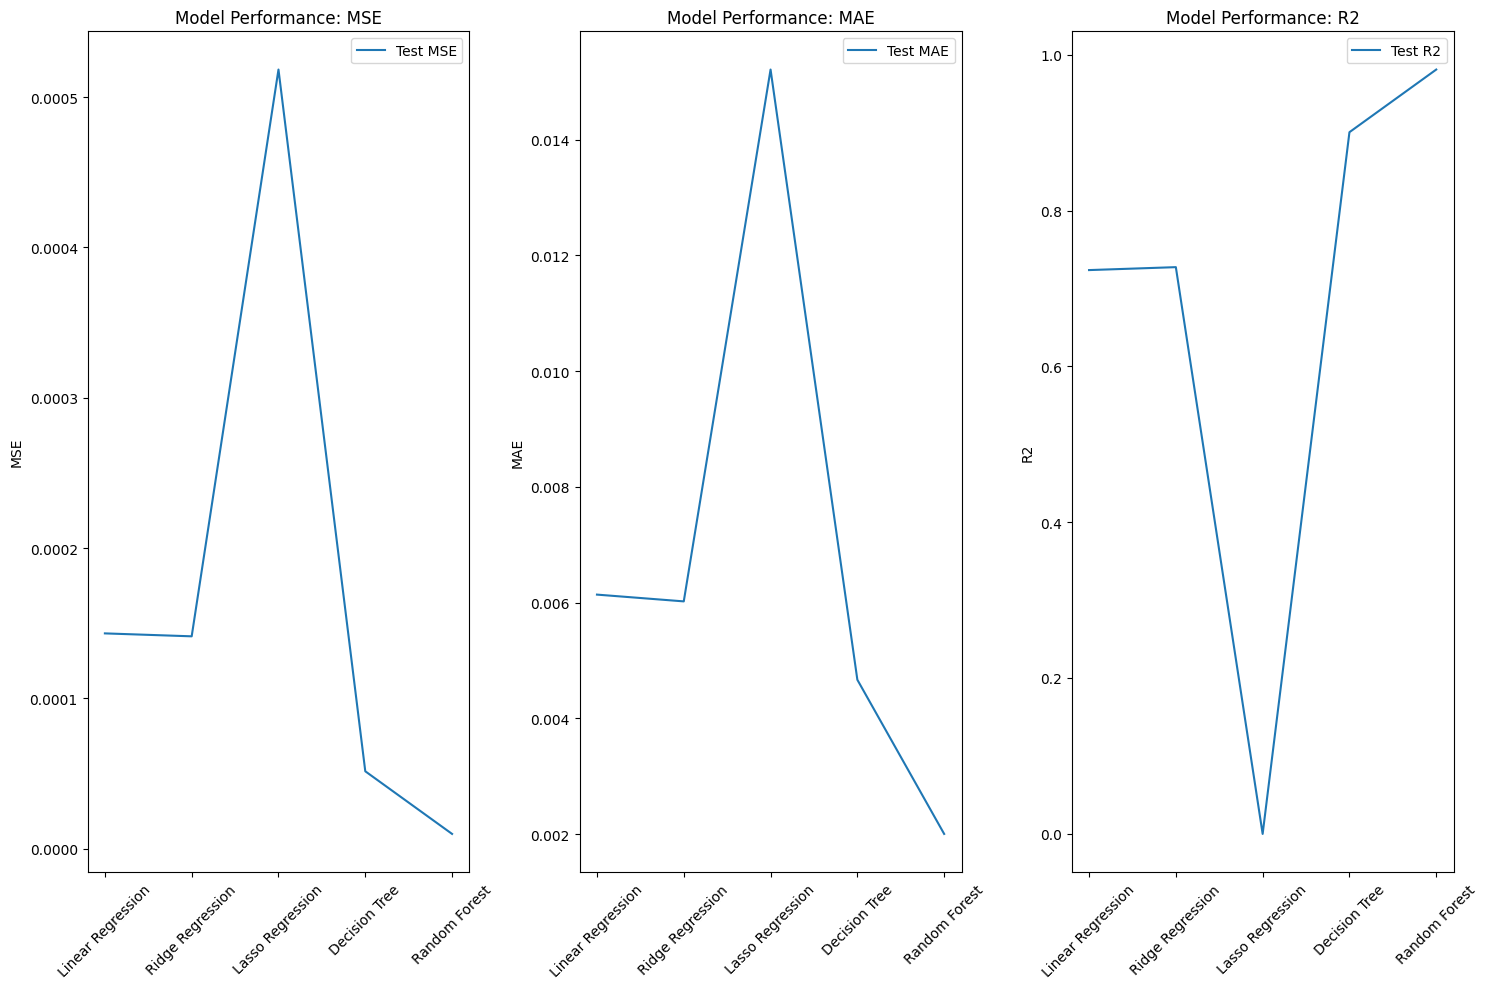

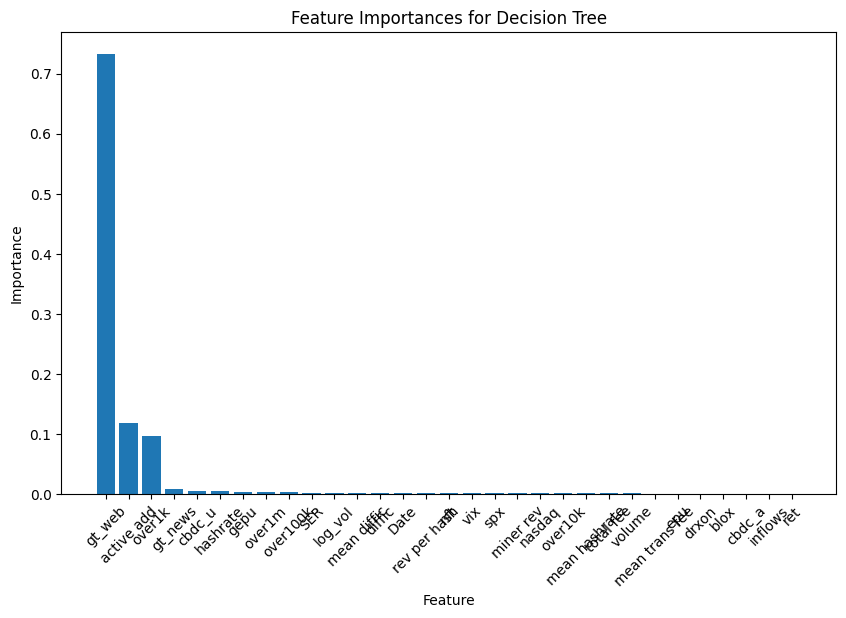

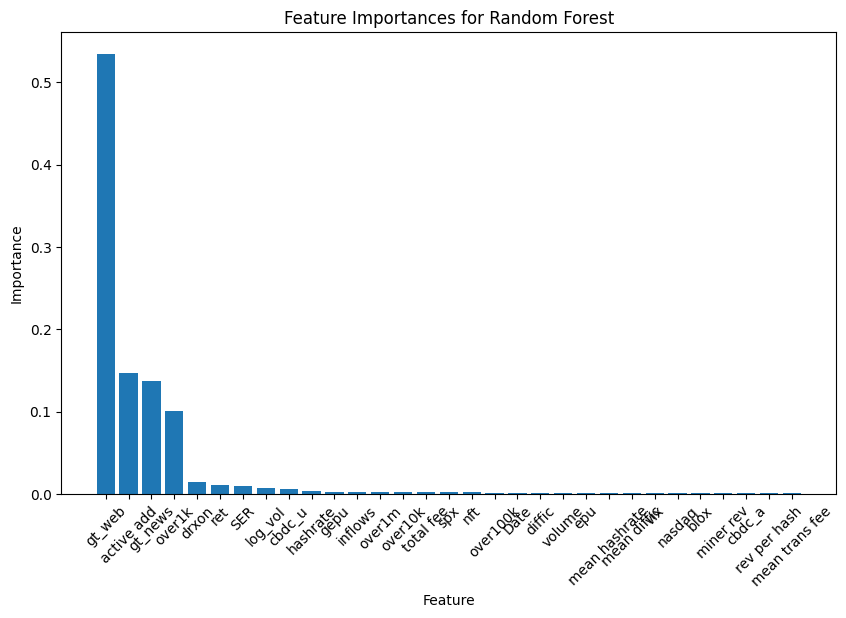

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime
from typing import Tuple

column_names = df.columns


# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor()
}


def custom_train_test_split(df: pd.DataFrame, cutoff_date: datetime, target_column_name: str) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    """
    Splits a DataFrame into training and testing sets based on a specified cutoff date.

    This function is designed to segment a dataset for time-series analysis, where the integrity
    of the temporal order is crucial. Data points before the cutoff date are used for training,
    while those on or after this date are reserved for testing. This method ensures that the
    testing data simulates a future period relative to the training data.

    Parameters:
    - df (pd.DataFrame): The complete dataset containing both features and the target variable.
    - cutoff_date (datetime): The date used to split the data. Data up to this date are included
      in the training set, while data from this date onwards are in the testing set.
    - target_column_name (str): The name of the target variable column in the dataset.

    Returns:
    - Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]: A tuple containing four elements:
      X_train (DataFrame), y_train (Series), X_test (DataFrame), and y_test (Series).
      X_train and X_test contain the features, while y_train and y_test contain the target variable.
    """
    df['Date'] = pd.to_datetime(df['Date'])
    train_data = df[df['Date'] < cutoff_date].reset_index(drop=True)
    test_data = df[df['Date'] >= cutoff_date].reset_index(drop=True)

    X_train = train_data[features]  # Ensure 'Date' is not in 'features'
    y_train = train_data[target_column_name]
    X_test = test_data[features]  # Ensure 'Date' is not in 'features'
    y_test = test_data[target_column_name]

    return X_train, y_train, X_test, y_test

# Define the cutoff date for splitting data
cutoff_date = datetime(2023, 1, 1)

# Split the data
X_train, y_train, X_test, y_test = custom_train_test_split(
    df=df,
    cutoff_date=cutoff_date,
    target_column_name=target
)

# Apply the Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


results = []
feature_importances = {}

# Loop through each model, train it, evaluate, and collect results
for name, model in models.items():
    # Train the model on the training data
    model.fit(X_train_scaled, y_train)

    # Evaluate the model on the test data
    test_predictions = model.predict(X_test_scaled)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    # Store the performance metrics for each model
    results.append({'Model': name, 'Test MSE': test_mse, 'Test MAE': test_mae, 'Test R2': test_r2})

    # If the model has feature importances, store them for later use
    if hasattr(model, 'feature_importances_'):
        feature_importances[name] = model.feature_importances_

# Convert the results list into a DataFrame for easier viewing
results_df = pd.DataFrame(results)
print(results_df)

# Plotting performance metrics for each model
metrics = ['MSE', 'MAE', 'R2']
plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics):
    # Create a subplot for each metric
    plt.subplot(1, 3, i+1)
    plt.plot(results_df['Model'], results_df[f'Test {metric}'], label=f'Test {metric}')
    plt.title(f'Model Performance: {metric}')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.legend()

plt.tight_layout()
plt.show()

# Plotting feature importances for each model (if available)
for model_name, importances in feature_importances.items():
    # Sort the feature importances in descending order
    indices = np.argsort(importances)[::-1]
    sorted_names = [column_names[i] for i in indices]

    # Create a bar plot for each model's feature importances
    plt.figure(figsize=(10, 6))
    plt.title(f'Feature Importances for {model_name}')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), sorted_names, rotation=45)
    plt.ylabel('Importance')
    plt.xlabel('Feature')
    plt.show()


## Experiment 2 - Split the training and testing across years, with scaling
This pipeline is useful to find the baseline scores of our model. We first split
the data into training, testing, and validation. We are going to scale after the split. Then apply 5 different models to test performance.
Once we evaluate these models, we then find the important features.

               Model  Test MSE  Test MAE   Test R2
0  Linear Regression  0.000143  0.006139  0.723506
1   Ridge Regression  0.000141  0.006022  0.727272
2   Lasso Regression  0.000518  0.015212 -0.000500
3      Decision Tree  0.000046  0.004478  0.911261
4      Random Forest  0.000009  0.001956  0.982358


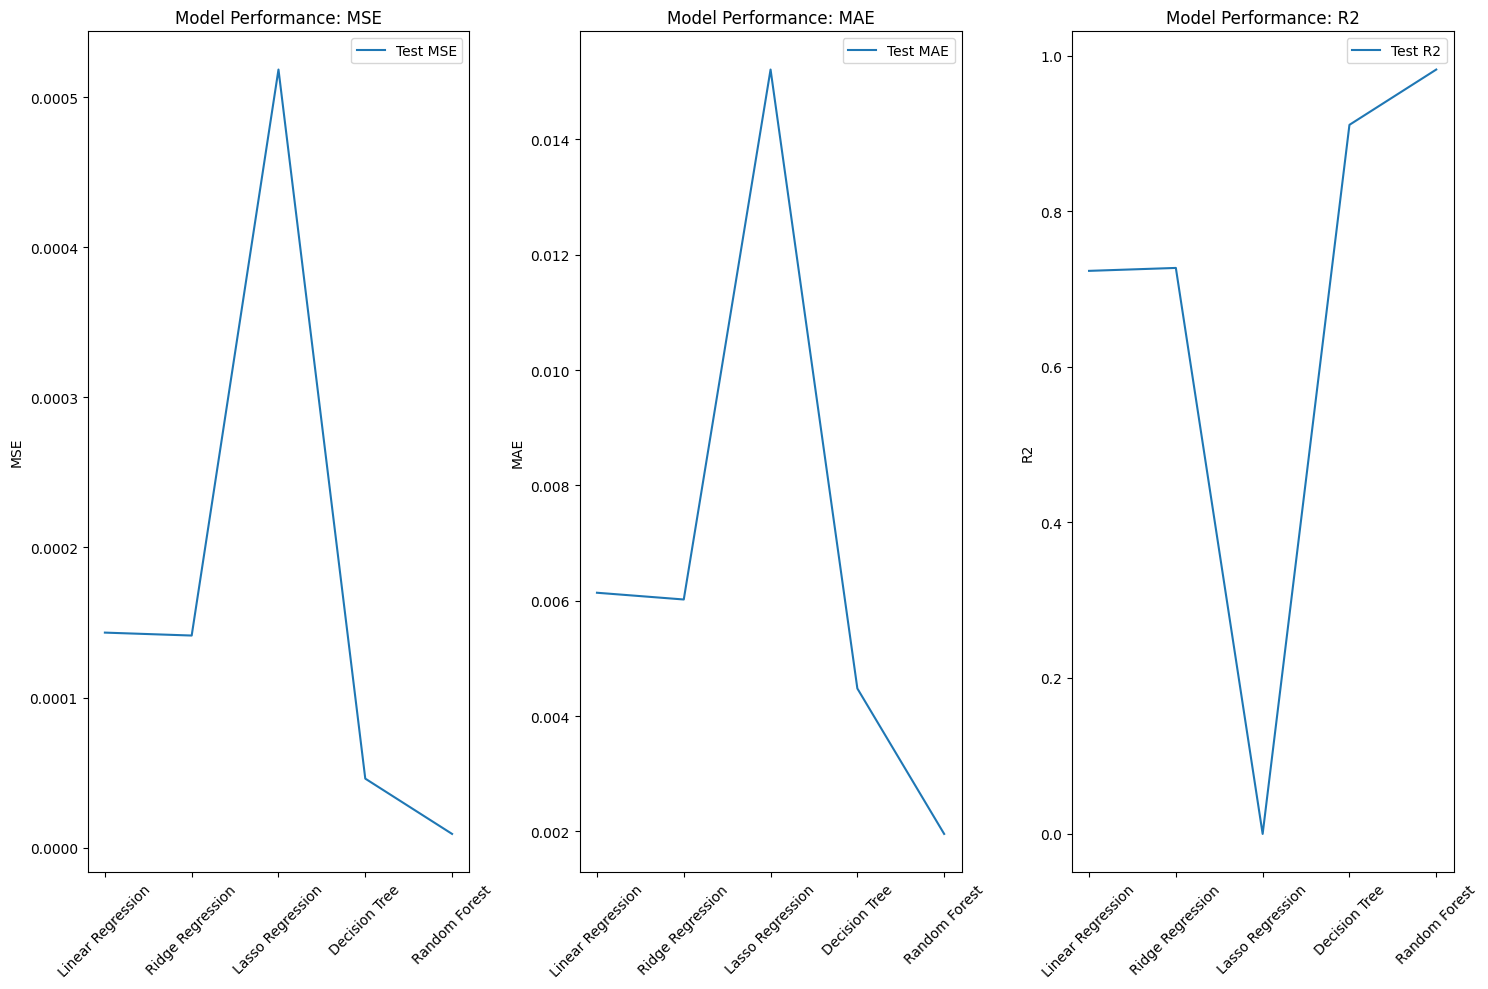

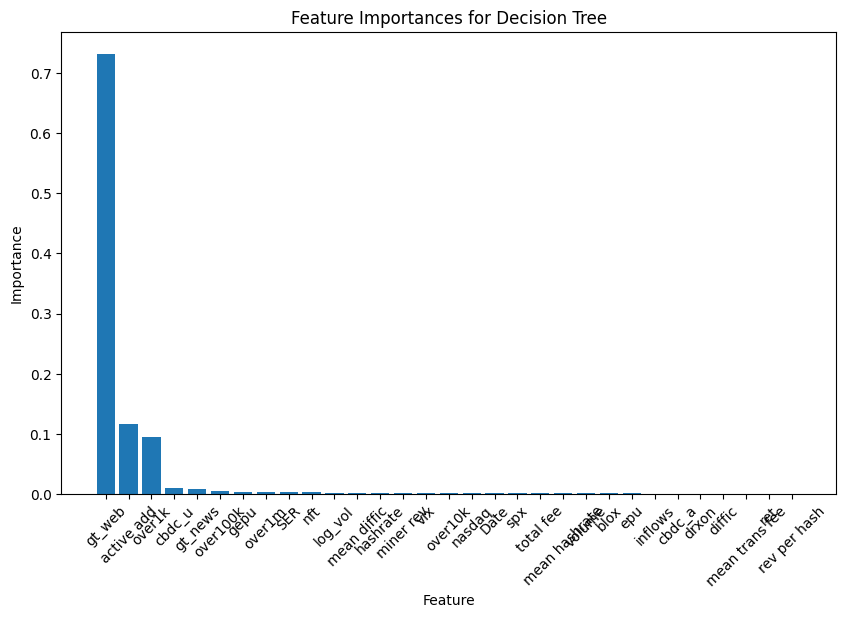

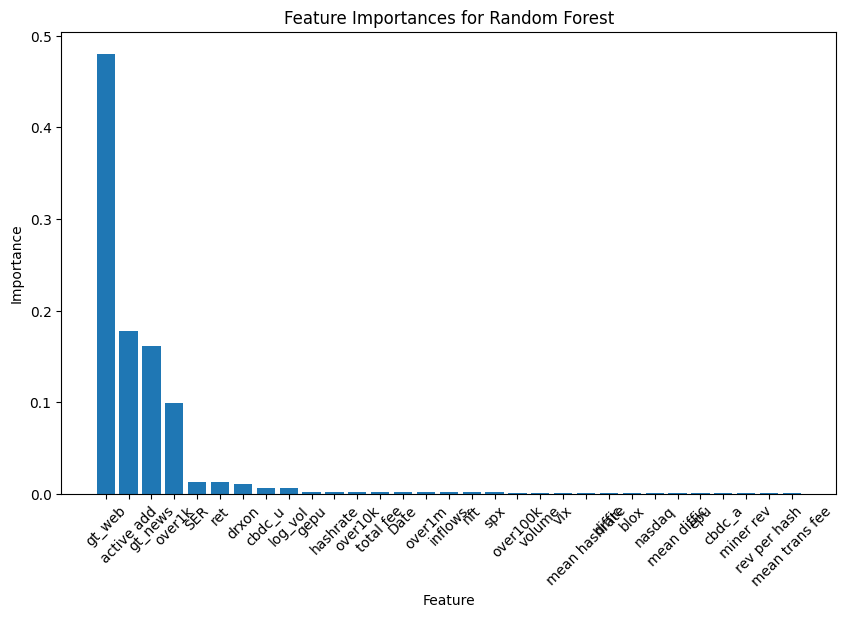

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load your data
# X, y = your_data, your_target
column_names = df.columns

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor()
}

def custom_train_test_split(df: pd.DataFrame, cutoff_date: datetime, target_column_name: str) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
  """
    Splits a DataFrame into training and testing sets based on a specified cutoff date.

    This function is designed to segment a dataset for time-series analysis, where the integrity
    of the temporal order is crucial. Data points before the cutoff date are used for training,
    while those on or after this date are reserved for testing. This method ensures that the
    testing data simulates a future period relative to the training data.

    Parameters:
    - df (pd.DataFrame): The complete dataset containing both features and the target variable.
    - cutoff_date (datetime): The date used to split the data. Data up to this date are included
      in the training set, while data from this date onwards are in the testing set.
    - target_column_name (str): The name of the target variable column in the dataset.

    Returns:
    - Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]: A tuple containing four elements:
      X_train (DataFrame), y_train (Series), X_test (DataFrame), and y_test (Series).
      X_train and X_test contain the features, while y_train and y_test contain the target variable.
    """

  df['Date'] = pd.to_datetime(df['Date'])
  train_data = df[df['Date'] < cutoff_date].reset_index(drop=True)
  test_data = df[df['Date'] >= cutoff_date].reset_index(drop=True)

  X_train = train_data[features]  # Ensure 'Date' is not in 'features'
  y_train = train_data[target_column_name]
  X_test = test_data[features]  # Ensure 'Date' is not in 'features'
  y_test = test_data[target_column_name]

  return X_train, y_train, X_test, y_test

# Define the cutoff date for splitting data
cutoff_date = datetime(2023, 1, 1)

# Split the data
X_train, y_train, X_test, y_test = custom_train_test_split(
    df=df,
    cutoff_date=cutoff_date,
    target_column_name=target
)

# Apply scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

results = []
feature_importances = {}

# Loop through each model, train it, evaluate, and collect results
for name, model in models.items():
    # Train the model on the training data
    model.fit(X_train_scaled, y_train)

    # Evaluate the model on the test data
    test_predictions = model.predict(X_test_scaled)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    # Store the performance metrics for each model
    results.append({'Model': name, 'Test MSE': test_mse, 'Test MAE': test_mae, 'Test R2': test_r2})

    # If the model has feature importances, store them for later use
    if hasattr(model, 'feature_importances_'):
        feature_importances[name] = model.feature_importances_

# Convert the results list into a DataFrame for easier viewing
results_df = pd.DataFrame(results)
print(results_df)

# Plotting performance metrics for each model
metrics = ['MSE', 'MAE', 'R2']
plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics):
    # Create a subplot for each metric
    plt.subplot(1, 3, i+1)
    plt.plot(results_df['Model'], results_df[f'Test {metric}'], label=f'Test {metric}')
    plt.title(f'Model Performance: {metric}')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.legend()

plt.tight_layout()
plt.show()

# Plotting feature importances for each model (if available)
for model_name, importances in feature_importances.items():
    # Sort the feature importances in descending order
    indices = np.argsort(importances)[::-1]
    sorted_names = [column_names[i] for i in indices]

    # Create a bar plot for each model's feature importances
    plt.figure(figsize=(10, 6))
    plt.title(f'Feature Importances for {model_name}')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), sorted_names, rotation=45)
    plt.ylabel('Importance')
    plt.xlabel('Feature')
    plt.show()


## Experiment 3 - Split the training and testing across years, with Normalization
This pipeline is useful to find the baseline scores of our model. We first split
the data into training, testing, and validation. We are going to scale after the split. Then apply 5 different models to test performance.
Once we evaluate these models, we then find the important features.

               Model  Test MSE  Test MAE   Test R2
0  Linear Regression  0.000143  0.006139  0.723506
1   Ridge Regression  0.000141  0.006022  0.727272
2   Lasso Regression  0.000518  0.015212 -0.000500
3      Decision Tree  0.000046  0.004551  0.910739
4      Random Forest  0.000008  0.001938  0.983653


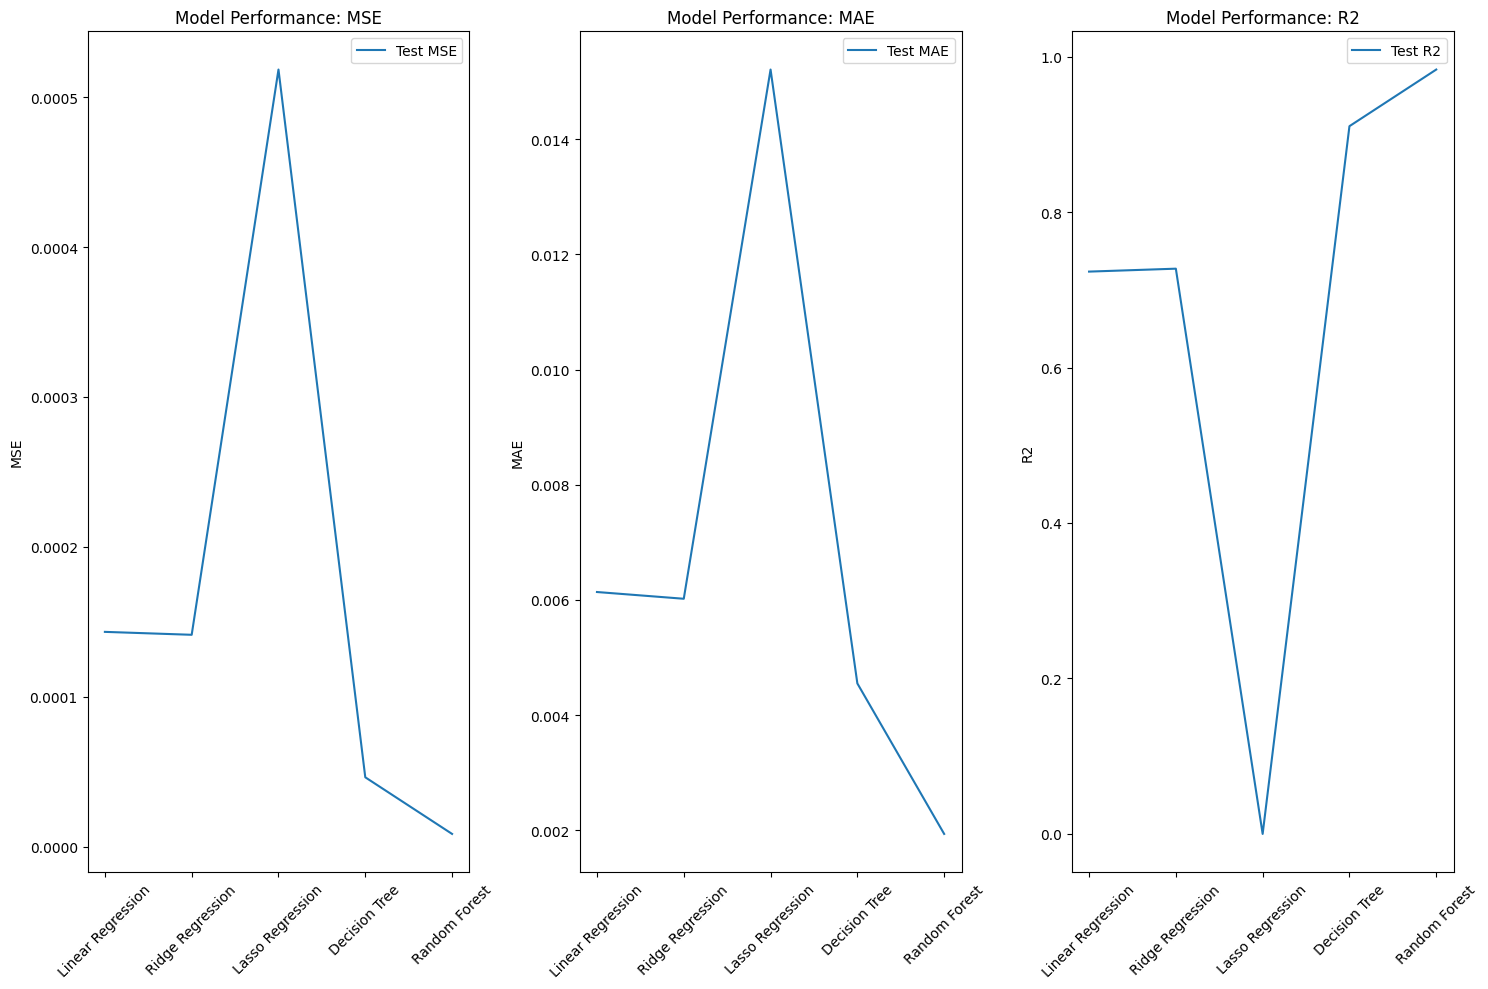

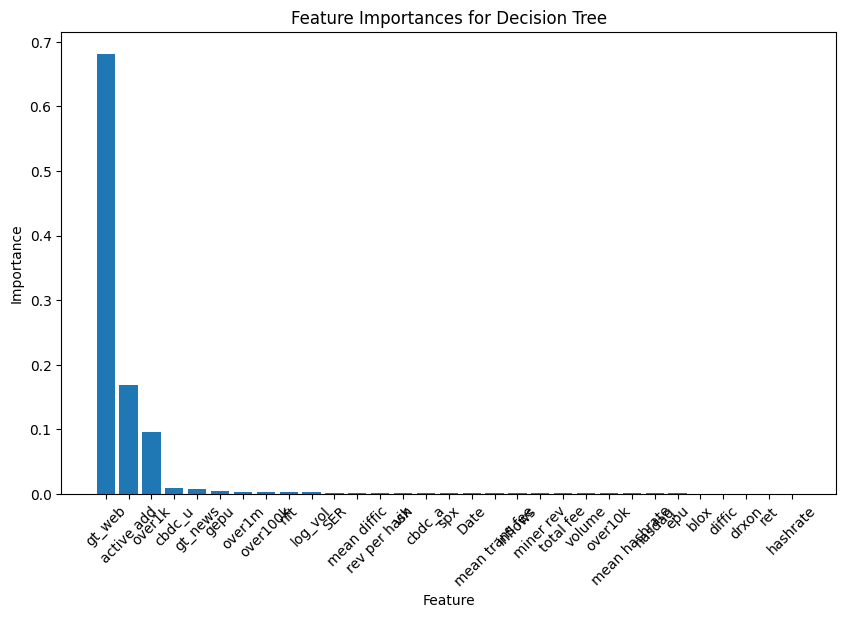

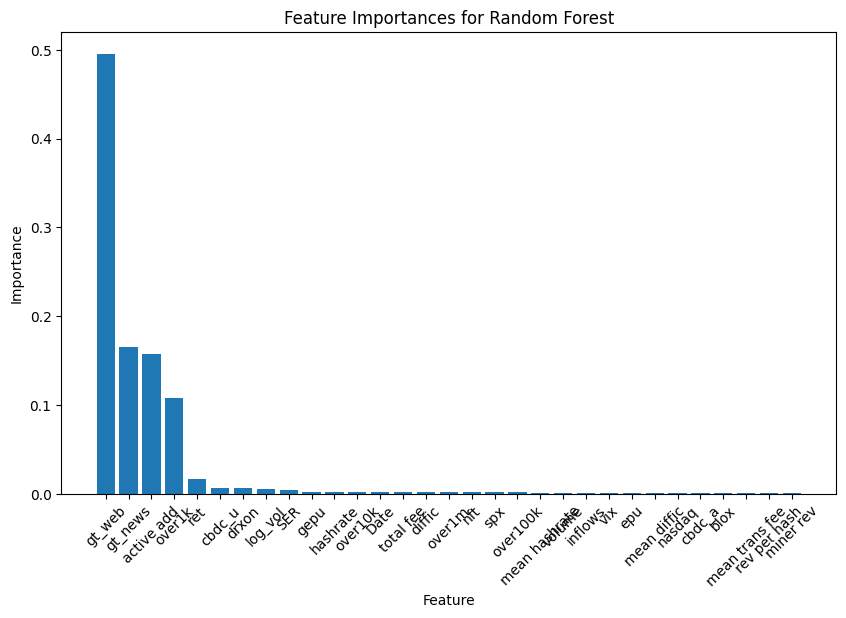

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime
from typing import Tuple

# Assuming df, features, and target are defined
# df = ... (Your DataFrame)
# features = ... (List of feature column names, excluding the 'Date' column)
# target = ... (Target column name)
column_names = df.columns

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor()
}

def custom_train_test_split(df: pd.DataFrame, cutoff_date: datetime, target_column_name: str) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    """
    Splits a DataFrame into training and testing sets based on a specified cutoff date.

    This function is designed to segment a dataset for time-series analysis, where the integrity
    of the temporal order is crucial. Data points before the cutoff date are used for training,
    while those on or after this date are reserved for testing. This method ensures that the
    testing data simulates a future period relative to the training data.

    Parameters:
    - df (pd.DataFrame): The complete dataset containing both features and the target variable.
    - cutoff_date (datetime): The date used to split the data. Data up to this date are included
      in the training set, while data from this date onwards are in the testing set.
    - target_column_name (str): The name of the target variable column in the dataset.

    Returns:
    - Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]: A tuple containing four elements:
      X_train (DataFrame), y_train (Series), X_test (DataFrame), and y_test (Series).
      X_train and X_test contain the features, while y_train and y_test contain the target variable.
    """

    df['Date'] = pd.to_datetime(df['Date'])
    train_data = df[df['Date'] < cutoff_date].reset_index(drop=True)
    test_data = df[df['Date'] >= cutoff_date].reset_index(drop=True)

    X_train = train_data[features]  # Ensure 'Date' is not in 'features'
    y_train = train_data[target_column_name]
    X_test = test_data[features]  # Ensure 'Date' is not in 'features'
    y_test = test_data[target_column_name]

    return X_train, y_train, X_test, y_test

# Define the cutoff date for splitting data
cutoff_date = datetime(2023, 1, 1)

# Split the data
X_train, y_train, X_test, y_test = custom_train_test_split(
    df=df,
    cutoff_date=cutoff_date,
    target_column_name=target
)

# Apply normalization
normalizer = MinMaxScaler()
X_train_normalized = normalizer.fit_transform(X_train)
X_test_normalized = normalizer.transform(X_test)

results = []
feature_importances = {}

# Loop through each model, train it, evaluate, and collect results
for name, model in models.items():
    # Train the model on the training data
    model.fit(X_train_scaled, y_train)

    # Evaluate the model on the test data
    test_predictions = model.predict(X_test_scaled)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    # Store the performance metrics for each model
    results.append({'Model': name, 'Test MSE': test_mse, 'Test MAE': test_mae, 'Test R2': test_r2})

    # If the model has feature importances, store them for later use
    if hasattr(model, 'feature_importances_'):
        feature_importances[name] = model.feature_importances_

# Convert the results list into a DataFrame for easier viewing
results_df = pd.DataFrame(results)
print(results_df)

# Plotting performance metrics for each model
metrics = ['MSE', 'MAE', 'R2']
plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics):
    # Create a subplot for each metric
    plt.subplot(1, 3, i+1)
    plt.plot(results_df['Model'], results_df[f'Test {metric}'], label=f'Test {metric}')
    plt.title(f'Model Performance: {metric}')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.legend()

plt.tight_layout()
plt.show()

# Plotting feature importances for each model (if available)
for model_name, importances in feature_importances.items():
    # Sort the feature importances in descending order
    indices = np.argsort(importances)[::-1]
    sorted_names = [column_names[i] for i in indices]

    # Create a bar plot for each model's feature importances
    plt.figure(figsize=(10, 6))
    plt.title(f'Feature Importances for {model_name}')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), sorted_names, rotation=45)
    plt.ylabel('Importance')
    plt.xlabel('Feature')
    plt.show()


## Experiment 4 - Split the training and testing across years, with Normalization, then run a LSTM RNN based on this architecture.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from datetime import datetime
from typing import Tuple

def custom_train_test_split(df: pd.DataFrame, cutoff_date: datetime, target_column_name: str) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    """
    Splits a DataFrame into training and testing sets based on a specified cutoff date.

    This function is designed to segment a dataset for time-series analysis, where the integrity
    of the temporal order is crucial. Data points before the cutoff date are used for training,
    while those on or after this date are reserved for testing. This method ensures that the
    testing data simulates a future period relative to the training data.

    Parameters:
    - df (pd.DataFrame): The complete dataset containing both features and the target variable.
    - cutoff_date (datetime): The date used to split the data. Data up to this date are included
      in the training set, while data from this date onwards are in the testing set.
    - target_column_name (str): The name of the target variable column in the dataset.

    Returns:
    - Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]: A tuple containing four elements:
      X_train (DataFrame), y_train (Series), X_test (DataFrame), and y_test (Series).
      X_train and X_test contain the features, while y_train and y_test contain the target variable.
    """

    df['Date'] = pd.to_datetime(df['Date'])
    train_data = df[df['Date'] < cutoff_date].reset_index(drop=True)
    test_data = df[df['Date'] >= cutoff_date].reset_index(drop=True)

    X_train = train_data[features]
    y_train = train_data[target_column_name]
    X_test = test_data[features]
    y_test = test_data[target_column_name]

    return X_train, y_train, X_test, y_test

def create_sequences(X, y, time_steps):
  """
    Converts time series data into a format suitable for training RNN models.

    This function creates sequences from the provided feature data (X) and the corresponding
    targets (y), with each sequence having a specified length (time_steps). The function
    iterates through the dataset, creating overlapping sequences of the input features and
    their corresponding next value as the target.

    Parameters:
    - X (array-like): Feature data for the time series. Typically a 2D array where each row
      represents a time point and each column a feature.
    - y (array-like): Target data for the time series. Usually a 1D array where each element
      corresponds to a time point.
    - time_steps (int): The number of time steps to include in each sequence, determining
      the sequence length.

    Returns:
    - Tuple[np.ndarray, np.ndarray]: Two numpy arrays, the first containing the sequences
      of features and the second containing the corresponding target values. Each sequence
      in the first array is paired with a single target value in the second array.
    """

  Xs, ys = [], []
  for i in range(len(X) - time_steps):
    Xs.append(X[i:(i + time_steps)])
    ys.append(y[i + time_steps])
  return np.array(Xs), np.array(ys)

# Example usage with the LSTM model
time_steps = 30  # This defines the sequence length

# Create sequences from the training and test data
#X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, time_steps)
#X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, time_steps)

# Define the cutoff date for splitting data
cutoff_date = datetime(2023, 1, 1)

# Split the data
X_train, y_train, X_test, y_test = custom_train_test_split(
    df=df,
    cutoff_date=cutoff_date,
    target_column_name=target
)

# Normalize the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create sequences for LSTM
# You need to implement create_sequences function based on your data
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps=30)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps=30)

# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, validation_split=0.1)

# Evaluate the model
test_predictions = model.predict(X_test_seq)
test_mse = mean_squared_error(y_test_seq, test_predictions)
print("Test MSE:", test_mse)

Epoch 1/100
61/61 [==============================] - 4s 18ms/step - loss: 0.0053 - val_loss: 0.0012
Epoch 2/100
61/61 [==============================] - 1s 10ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 3/100
61/61 [==============================] - 1s 9ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 4/100
61/61 [==============================] - 1s 10ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 5/100
61/61 [==============================] - 1s 10ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 6/100
61/61 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 7/100
61/61 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 8/100
61/61 [==============================] - 1s 8ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 9/100
61/61 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 10/100
61/61 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 0.0013
Epoc

## Experiment 5 - Split the training and testing across years, with Normalization, then run a GRU RNN based on this architecture.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from datetime import datetime
from typing import Tuple

def custom_train_test_split(df: pd.DataFrame, cutoff_date: datetime, target_column_name: str) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    df['Date'] = pd.to_datetime(df['Date'])
    train_data = df[df['Date'] < cutoff_date].reset_index(drop=True)
    test_data = df[df['Date'] >= cutoff_date].reset_index(drop=True)

    X_train = train_data[features]
    y_train = train_data[target_column_name]
    X_test = test_data[features]
    y_test = test_data[target_column_name]

    return X_train, y_train, X_test, y_test

def create_sequences(X, y, time_steps):

   """
    Converts time series data into a format suitable for training RNN models.

    This function creates sequences from the provided feature data (X) and the corresponding
    targets (y), with each sequence having a specified length (time_steps). The function
    iterates through the dataset, creating overlapping sequences of the input features and
    their corresponding next value as the target.

    Parameters:
    - X (array-like): Feature data for the time series. Typically a 2D array where each row
      represents a time point and each column a feature.
    - y (array-like): Target data for the time series. Usually a 1D array where each element
      corresponds to a time point.
    - time_steps (int): The number of time steps to include in each sequence, determining
      the sequence length.

    Returns:
    - Tuple[np.ndarray, np.ndarray]: Two numpy arrays, the first containing the sequences
      of features and the second containing the corresponding target values. Each sequence
      in the first array is paired with a single target value in the second array.
    """

    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Example usage with the LSTM model
time_steps = 30  # This defines the sequence length

# Create sequences from the training and test data
#X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, time_steps)
#X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, time_steps)

# Now X_train_seq, y_train_seq, X_test_seq, and y_test_seq are ready to be used in an RNN model


# Define the cutoff date for splitting data
cutoff_date = datetime(2023, 1, 1)

# Split the data
X_train, y_train, X_test, y_test = custom_train_test_split(
    df=df,
    cutoff_date=cutoff_date,
    target_column_name=target
)

# Normalize the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create sequences for LSTM
# You need to implement create_sequences function based on your data
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps=30)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps=30)

# Define the GRU model
model = Sequential([
    GRU(50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    GRU(50),
    Dropout(0.2),
    Dense(1)
])

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, validation_split=0.1)

# Evaluate the model
test_predictions = model.predict(X_test_seq)
test_mse = mean_squared_error(y_test_seq, test_predictions)
print("Test MSE:", test_mse)

Epoch 1/100
61/61 [==============================] - 5s 18ms/step - loss: 0.0165 - val_loss: 0.0012
Epoch 2/100
61/61 [==============================] - 0s 7ms/step - loss: 0.0045 - val_loss: 0.0012
Epoch 3/100
61/61 [==============================] - 0s 7ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 4/100
61/61 [==============================] - 0s 7ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 5/100
61/61 [==============================] - 0s 7ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 6/100
61/61 [==============================] - 0s 7ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 7/100
61/61 [==============================] - 0s 7ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 8/100
61/61 [==============================] - 0s 7ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 9/100
61/61 [==============================] - 0s 7ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 10/100
61/61 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 11